## Fit baseline model using flight delay averages

- Takes the model input data for flight delays
- Split data based on external train/test data file
- Define baseline average model
- Evaluate model
- Save model as pickle
- -- save to mlflow -- 
- Write prediction prediction output to csv

### Parameters

-------------------
- `input_file`: Filepath of model input data of flight delays
- `train_test_file`: Filepath of train/test csv file with columns ["id", "model_set"]
- `output_file`: Filepath to write output csv file with minimal modelling input


### Returns

-----------------

Trained baseline model that simply predicts the average flight delay from the training
data in all predictions.


In [1]:
input_file = "../lvt-schiphol-assignment-snakemake/data/model_input/delays_extended_input.csv"
train_test_file = "../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__timeseries.csv"
output_predictions = "./predictions.csv"

In [2]:
from pathlib import Path
output_dir = Path(output_predictions).parent.absolute()
output_dir

WindowsPath('C:/Users/Lodewic/qualogy-git/schiphol-assignment/scripts')

## Imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

# catboost
from catboost import Pool
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../")

from src.data.google_storage_io import read_csv_data, write_csv_data
from src.evaluation.metrics import get_regression_metrics
from src.evaluation.regression import make_regression_metrics_by_group, make_regression_metrics_by_datetime
from src.evaluation.predictions import make_predictions_dataframe

# Read data

In [4]:
%%time
df = read_csv_data(input_file)
train_test = read_csv_data(train_test_file)

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/delays_extended_input.csv

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/train_test__0.2__timeseries.csv

Wall time: 1.63 s


In [5]:
%%time

def split_train_test(df, train_test, target="scheduleDelaySeconds"):
    # merge by `id` and group by train/test set labels
    df_set_groups = pd.merge(df, train_test, on="id", how="left").groupby("model_set")
    
    # get data per train/test set
    df_train = df_set_groups.get_group("train").drop(columns="model_set")
    df_test = df_set_groups.get_group("test").drop(columns="model_set")
    
    # split target from features
    X_train, y_train = df_train.drop(columns=[target]), df_train[target]
    X_test, y_test = df_test.drop(columns=[target]),  df_test[target]
    
    print(f"""
        Split data shapes
        Input: {df.shape}
        Train: {X_train.shape},\t {y_train.shape} 
        Test:  {X_test.shape},\t {y_test.shape}
        """)
    
    # assert that we haven't dropped values at this stage
    # failed assert could indicate duplicate ids found in the data
    assert (len(X_train) + len(X_test)) == len(df)
    
    return X_train, X_test, y_train, y_test

# split data
X_train, X_test, y_train, y_test = split_train_test(df, train_test)




        Split data shapes
        Input: (487716, 24)
        Train: (389441, 23),	 (389441,) 
        Test:  (98275, 23),	 (98275,)
        
Wall time: 955 ms


# Prediction model

## Define model

In [6]:
class CatBoostChain(BaseEstimator, TransformerMixin):
    """
    Catboost estimator that uses .transform() to append output predictions
    """
    def __init__(self, catboost_kwargs, early_stopping_rounds=None):
        self.catboost = CatBoostRegressor(**catboost_kwargs)
        self.early_stopping_rounds = early_stopping_rounds
        
    def fit(self, X, y, **kwargs):
        """
        Expects 'y' to be the race finish times- not avg_speed_left
        """
        # calculate avg speed left
        y =  ((X["distance"] - X["Passed"]) / (y.values - X["seconds"])) \
            .replace([np.inf, -np.inf], np.nan) \
            .fillna(0).values
    
        X_pool_train, X_pool_eval, y_pool_train, y_pool_eval = train_test_split(X, y, test_size=0.2)

        train_pool = Pool(data=X_pool_train,
                          label=y_pool_train,
                          cat_features=self.catboost.get_param("cat_features"))
#                                   baseline=X_dist_train["yhat_finish_time"])

        eval_pool = Pool(data=X_pool_eval,
                         label=y_pool_eval,
                         cat_features=self.catboost.get_param("cat_features"))
        
        self.catboost.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=self.early_stopping_rounds, **kwargs)
        
        return self

### Select features for catboost model



In [7]:
columns_to_drop = ["id", "scheduleDateTime", "actualOffBlockTime", "year", "month", "quarter"]
X_train_meta = X_train[["id", "scheduleDateTime"]]
X_test_meta = X_test[["id", "scheduleDateTime"]]

X_train = X_train[[col for col in X_train.columns if col not in columns_to_drop]]
X_test = X_test[[col for col in X_test.columns if col not in columns_to_drop]]

# type categorical features for catboost
cat_features = [
    'aircraftRegistration', 'airlineCode', 'terminal', 'serviceType',
    'final_destination', 'Country', 'City', 'DST',
    'dayofweek', 'dayofmonth', 'weekofyear', 'hour', 'minutes'
]

X_train[cat_features] = X_train[cat_features].astype(str).astype('category')
X_test[cat_features] = X_test[cat_features].astype(str).astype('category')

assert all(X_test.columns == X_train.columns)

X_train.columns

Index(['aircraftRegistration', 'airlineCode', 'terminal', 'serviceType',
       'dayofweek', 'dayofmonth', 'weekofyear', 'hour', 'minutes',
       'final_destination', 'Country', 'City', 'Latitude', 'Longitude',
       'Altitude', 'DST', 'destination_distance'],
      dtype='object')

In [8]:
# create catboost input data
X_pool_train, X_pool_eval, y_pool_train, y_pool_eval = train_test_split(X_train, y_train, test_size=0.2)

train_pool = Pool(data=X_pool_train,
                  label=y_pool_train,
                  cat_features=cat_features)

eval_pool = Pool(data=X_pool_eval,
                 label=y_pool_eval,
                 cat_features=cat_features)

# set initial catboost kwargs for random search
catboost_kwargs={
        "verbose": 1, 
        "iterations": 10,
        "depth": 4,
        "learning_rate": 1,
        "loss_function": "MAE",
        "l2_leaf_reg": 4,
        "cat_features": cat_features}

grid = {'learning_rate': [0.1, 0.3, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
search_model = CatBoostRegressor(**catboost_kwargs)
randomized_search_result = search_model.randomized_search(grid,
                                                   X=train_pool,
                                                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 822.7034469
bestIteration = 9

0:	loss: 822.7034469	best: 822.7034469 (0)	total: 1.16s	remaining: 10.5s

bestTest = 780.2126331
bestIteration = 9

1:	loss: 780.2126331	best: 780.2126331 (1)	total: 2s	remaining: 8.02s

bestTest = 773.1038856
bestIteration = 9

2:	loss: 773.1038856	best: 773.1038856 (2)	total: 2.82s	remaining: 6.59s

bestTest = 780.2126331
bestIteration = 9

3:	loss: 780.2126331	best: 773.1038856 (2)	total: 3.64s	remaining: 5.45s

bestTest = 773.1038856
bestIteration = 9

4:	loss: 773.1038856	best: 773.1038856 (2)	total: 4.44s	remaining: 4.44s

bestTest = 780.2126331
bestIteration = 9

5:	loss: 780.2126331	best: 773.1038856 (2)	total: 5.26s	remaining: 3.51s

bestTest = 773.1038856
bestIteration = 9

6:	loss: 773.1038856	best: 773.1038856 (2)	total: 6.06s	remaining: 2.6s

bestTest = 814.6849676
bestIteration = 9

7:	loss: 814.6849676	best: 773.1038856 (2)	total: 7s	remaining: 1.75s

bestTest = 772.8768704
bestIteration = 9

8:	loss: 772.8768704	best: 772.87687

## Train model

In [9]:
# update catboost parameters with randomized search results
updated_catboost_kwargs = dict(
    catboost_kwargs,
    iterations = 200,
    **randomized_search_result['params'])

# create new catboost object with updated parameters
model = CatBoostRegressor(**updated_catboost_kwargs)
# train final model
model.fit(train_pool, eval_set = eval_pool, early_stopping_rounds=50, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 750.5932360	test: 757.0313775	best: 757.0313775 (0)	total: 453ms	remaining: 1m 30s
1:	learn: 726.3118604	test: 732.4279637	best: 732.4279637 (1)	total: 797ms	remaining: 1m 18s
2:	learn: 695.9153030	test: 694.8778978	best: 694.8778978 (2)	total: 1.22s	remaining: 1m 19s
3:	learn: 680.9123997	test: 676.2923658	best: 676.2923658 (3)	total: 1.57s	remaining: 1m 16s
4:	learn: 666.0147205	test: 658.7099746	best: 658.7099746 (4)	total: 1.91s	remaining: 1m 14s
5:	learn: 661.2464723	test: 653.0954929	best: 653.0954929 (5)	total: 2.24s	remaining: 1m 12s
6:	learn: 654.0922270	test: 645.8054986	best: 645.8054986 (6)	total: 2.52s	remaining: 1m 9s
7:	learn: 652.5115543	test: 644.1488546	best: 644.1488546 (7)	total: 2.9s	remaining: 1m 9s
8:	learn: 648.3641208	test: 639.4033232	best: 639.4033232 (8)	total: 3.27s	remaining: 1m 9s
9:	learn: 645.9710281	test: 636.8745417	best: 636.8745417 (9)	total: 3.62s	remaining: 1m 8s
10:	learn: 645.0298919	test: 635.8234148	best: 635.8234148 (10)	total: 3.89

# Evaluate model

In [10]:
def datetime_to_date(dt):
    return pd.to_datetime(dt, utc=True).dt.date

def datetime_to_date_hour(dt):
    return pd.to_datetime(dt, utc=True).dt.floor('H')


In [11]:
# create predictions on train/test sets
df_predictions = make_predictions_dataframe(model, X_train, X_test, y_train, y_test,
                                           meta_train = X_train_meta,
                                           meta_test = X_test_meta)
df_predictions

id           scheduleDateTime       y          yhat  \
0       123414481790510775  2018-01-01 03:30:00+01:00  -480.0   -245.305845   
1       123414479288269149  2018-01-01 06:00:00+01:00   -98.0   -135.964822   
2       123414479666542945  2018-01-01 06:05:00+01:00  -300.0    -47.965334   
3       123414479288365061  2018-01-01 06:05:00+01:00  -300.0    -69.620114   
4       123414479288274329  2018-01-01 06:15:00+01:00   694.0    910.500523   
...                    ...                        ...     ...           ...   
487711  124763270719624901  2018-07-12 17:25:00+02:00    80.0  15176.270833   
487712  124763272032451639  2018-07-12 17:25:00+02:00    80.0  15171.704295   
487713  124763270368084713  2018-07-12 17:25:00+02:00    12.0  15135.671919   
487714  124763270625998761  2018-07-12 17:45:00+02:00 -1935.0  15045.992916   
487715  124763271129903067  2018-07-12 17:50:00+02:00 -8690.0  15321.612592   

               error model_set  
0         234.694155     train  
1         -37.964822     train  
2         252.034666     train  
3         230.379886     train  
4         216.500523     train  
...              ...       ...  
487711  15096.270833      test  
487712  15091.704295      test  
487713  15123.671919      test  
487714  16980.992916      test  
487715  24011.612592      test  

[487716 rows x 6 columns]

### Calculate regression metrics

In [12]:
%%time

df_metrics_long = make_regression_metrics_by_group(df_predictions, group_cols = ["model_set"])
df_daily_metrics_long = make_regression_metrics_by_datetime(df_predictions, freq="D", alias="schedule_date")
df_hourly_metrics_long = make_regression_metrics_by_datetime(df_predictions, freq="H", alias="schedule_date")

Wall time: 8.4 s


In [13]:
df_metrics_long.head()

model_set variable        value
0      test      mae  5575.634264
1     train      mae   574.351075
2      test     mape   169.446814
3     train     mape   459.204131
4      test     rmse  9329.689653

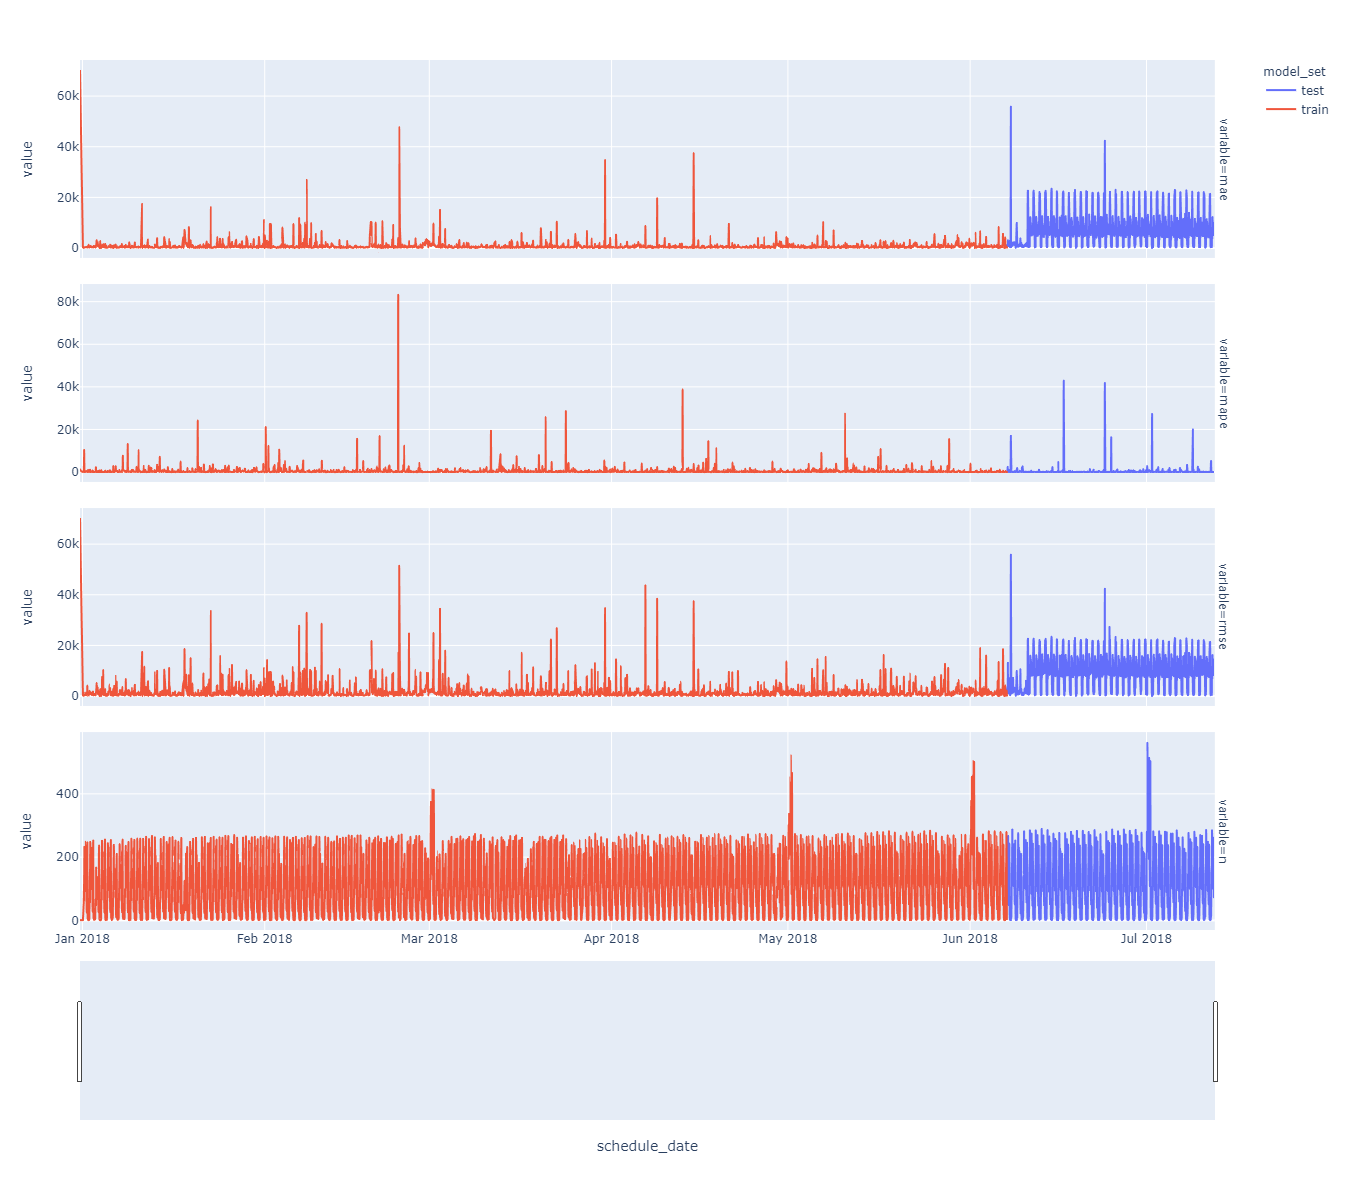

In [25]:
import plotly.express as px
fig = px.line(df_hourly_metrics_long, x="schedule_date", y="value", facet_row="variable", color="model_set",
             width=1200, height=1200)
# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    ),
    hovermode="x"
)
fig.update_yaxes(matches=None)
# fig.update_xaxes(matches=None)
fig.show()

## Plot some prediction results

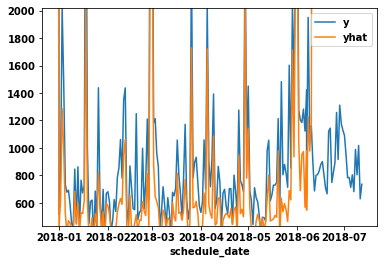

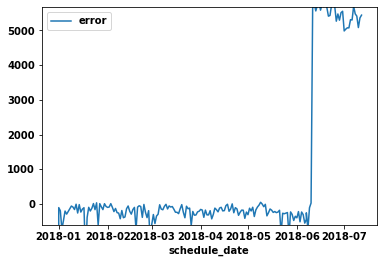

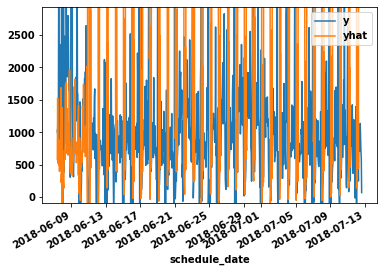

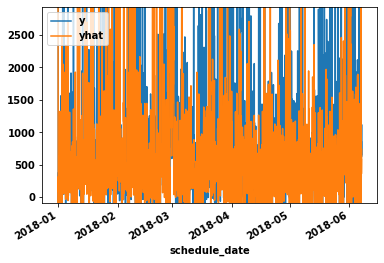

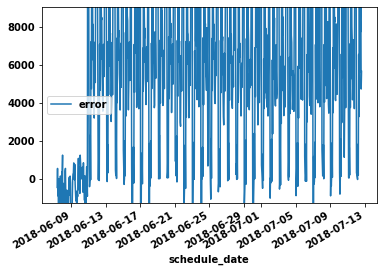

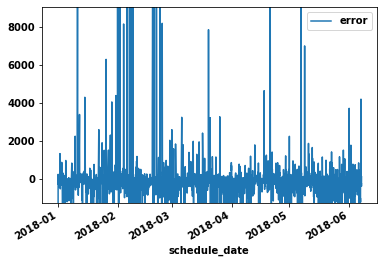

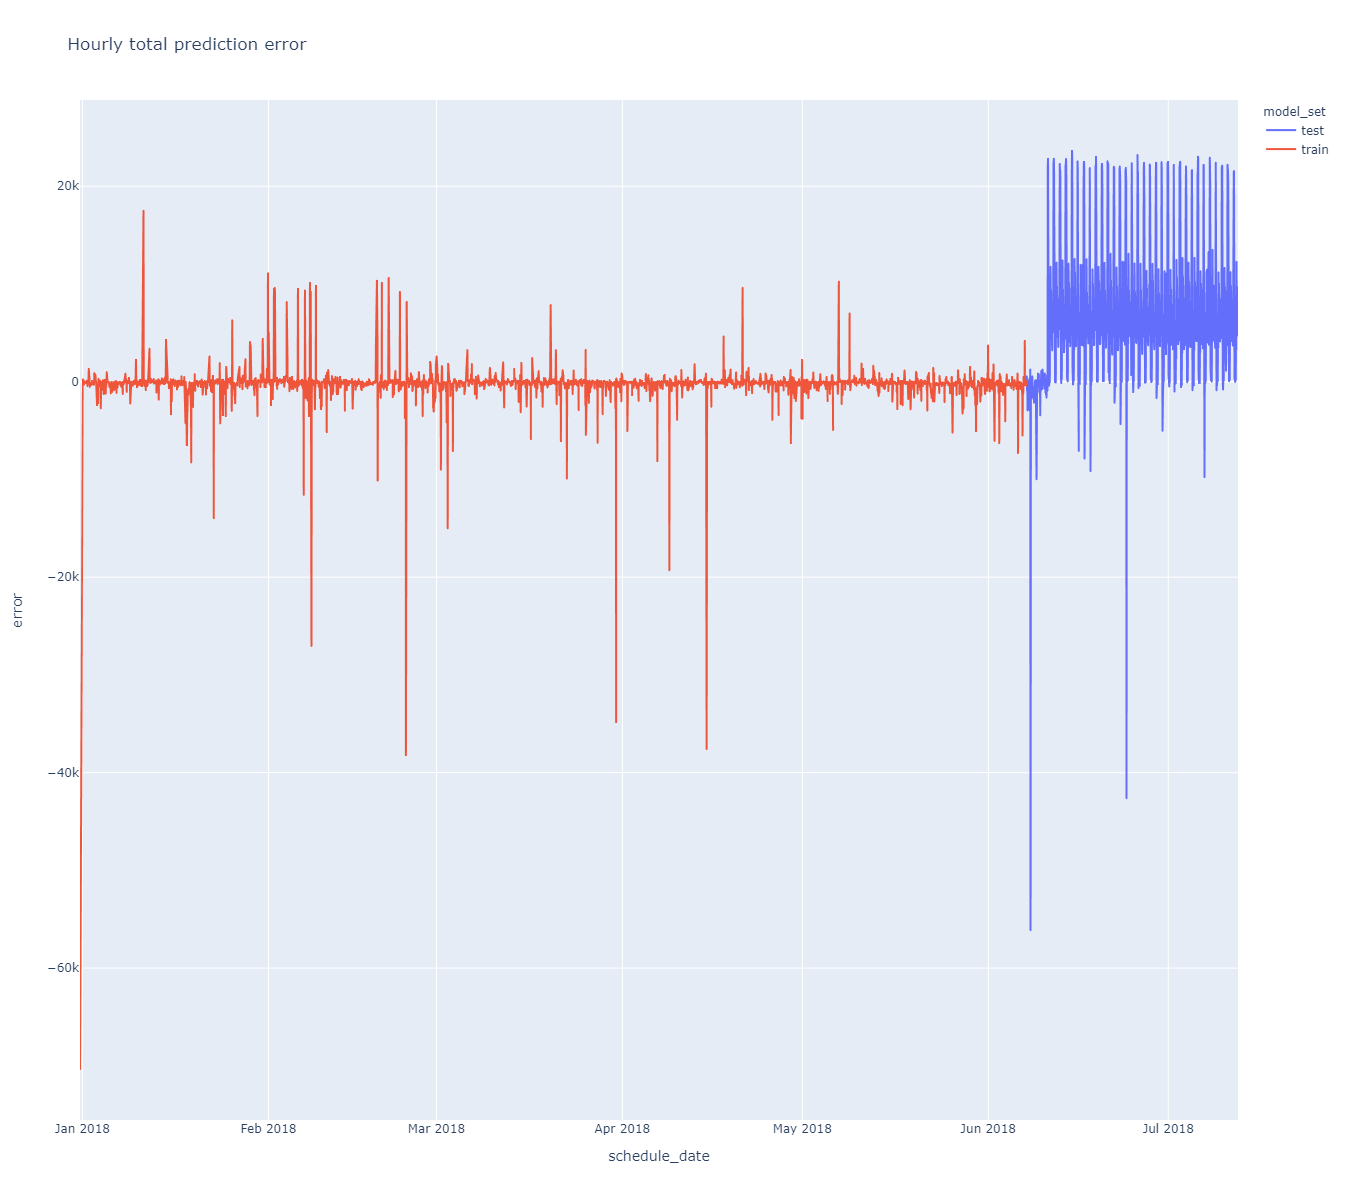

In [15]:
def predictions_daily_mean(df_predictions):
    df_predictions["schedule_date"] = datetime_to_date(df_predictions["scheduleDateTime"])
    df_predictions = df_predictions.drop(columns="id")
    df_daily_mean = df_predictions.groupby(["model_set", "schedule_date"]).mean().reset_index()
    return df_daily_mean

def predictions_hourly_mean(df_predictions):
    df_predictions["schedule_date"] = datetime_to_date_hour(df_predictions["scheduleDateTime"])
    df_predictions = df_predictions.drop(columns="id")
    df_daily_mean = df_predictions.groupby(["model_set", "schedule_date"]).mean().reset_index()
    return df_daily_mean

def get_safe_ylim(y, q=0.05, q2=None):
    if q2 is None:
        q2 = 1 - q
    return (np.quantile(y, q), np.quantile(y, q2))


df_daily_mean = predictions_daily_mean(df_predictions)
y_ylim = get_safe_ylim(df_daily_mean["y"])
error_ylim = get_safe_ylim(df_daily_mean["error"])

df_daily_mean[["schedule_date", "y", "yhat", "model_set"]].plot(x="schedule_date", ylim=y_ylim)
df_daily_mean[["schedule_date", "error", "model_set"]].plot(x="schedule_date", ylim=error_ylim)

df_hourly_mean = predictions_hourly_mean(df_predictions)
y_ylim = get_safe_ylim(df_hourly_mean["y"])
error_ylim = get_safe_ylim(df_hourly_mean["error"])

df_hourly_mean[["schedule_date", "y", "yhat", "model_set"]].groupby("model_set").plot(x="schedule_date", ylim=y_ylim)
df_hourly_mean[["schedule_date", "error", "model_set"]].groupby("model_set").plot(x="schedule_date", ylim=error_ylim)

df_hourly_mean[["schedule_date", "y", "yhat", "error", "model_set"]]
plt.show()

fig = px.line(df_hourly_mean, x="schedule_date", y="error", color="model_set",
             width=1200, height=1200, title="Hourly total prediction error")
fig.update_yaxes(matches=None)
fig.update_xaxes(matches=None)
fig.show()

# Write output to output directory

In [16]:
import joblib, pickle
from pathlib import Path

## Pickle output files for mlflow artifacts

- Pipeline serialized with `joblib`
- Model data or sample thereof 



In [17]:
joblib.dump(model, Path(output_dir, "model.pkl")) 

['C:\\Users\\Lodewic\\qualogy-git\\schiphol-assignment\\scripts\\model.pkl']

## Write output to CSV

Local or Google Storage is both handled

In [18]:
# write output file
write_csv_data(df_predictions, str(Path(output_dir, "predictions.csv")), index=False)
write_csv_data(df_metrics_long, str(Path(output_dir, "overall_metrics_long.csv")), index=False)
write_csv_data(df_daily_metrics_long, str(Path(output_dir, "daily_metrics_long.csv")), index=False)
write_csv_data(df_hourly_metrics_long, str(Path(output_dir, "hourly_metrics_long.csv")), index=False)

Writing file to local directory
File:	C:\Users\Lodewic\qualogy-git\schiphol-assignment\scripts\predictions.csv

Writing file to local directory
File:	C:\Users\Lodewic\qualogy-git\schiphol-assignment\scripts\overall_metrics_long.csv

Writing file to local directory
File:	C:\Users\Lodewic\qualogy-git\schiphol-assignment\scripts\daily_metrics_long.csv

Writing file to local directory
File:	C:\Users\Lodewic\qualogy-git\schiphol-assignment\scripts\hourly_metrics_long.csv



### Overview of the output data

In [19]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487716 entries, 0 to 487715
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                487716 non-null  int64              
 1   scheduleDateTime  487716 non-null  object             
 2   y                 487716 non-null  float64            
 3   yhat              487716 non-null  float64            
 4   error             487716 non-null  float64            
 5   model_set         487716 non-null  object             
 6   schedule_date     487716 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(2)
memory usage: 29.8+ MB
